**Load an instance of the Graph DB**

In [39]:
from langchain_community.graphs import Neo4jGraph

In [40]:
NEO4J_URL = "neo4j://localhost:7687"
NEO4J_USERNAME = "neo4j"
NEO4J_PASSWORD = "fireinthehole"
NEO4J_DATABASE = 'neo4j'

In [41]:
graph = Neo4jGraph(url=NEO4J_URL, username=NEO4J_USERNAME, password=NEO4J_PASSWORD, database=NEO4J_DATABASE)

**Delete first** 

In [42]:
# Delete everything in a database
cypher = """
MATCH (n)
DETACH DELETE n
"""
graph.query(cypher)

[]

In [43]:
graph.refresh_schema()
print(graph.schema)

Node properties:

Relationship properties:

The relationships:



**Build knowledge graph**

1. Download database dump file from [here](https://github.com/neo4j-graph-examples/recommendations/blob/main/data/recommendations-50.dump), save into `data` directory.
2. Copy dump file to container: `docker cp data/recommendations-50.dump neo4j_db:/var/lib/neo4j/import/recommendations.dump`.
3. Exec into the container: `docker exec -it neo4j_db bash`
4. In the container, run neo4j-admin to load database `recommendations`: `neo4j-admin database load --verbose --from-path=/var/lib/neo4j/import/ recommendations`
```
root@657beeef60c7:/var/lib/neo4j# neo4j-admin database load --verbose --from-path=/var/lib/neo4j/import/ recommendations
Executing command line: /opt/java/openjdk/bin/java -cp /var/lib/neo4j/plugins/*:/var/lib/neo4j/conf/*:/var/lib/neo4j/lib/* -XX:+UseParallelGC -XX:-OmitStackTraceInFastThrow -XX:+UnlockExperimentalVMOptions -XX:+TrustFinalNonStaticFields -XX:+DisableExplicitGC -Djdk.nio.maxCachedBufferSize=1024 -Dio.netty.tryReflectionSetAccessible=true -XX:+ExitOnOutOfMemoryError -Djdk.tls.ephemeralDHKeySize=2048 -XX:FlightRecorderOptions=stackdepth=256 -XX:+UnlockDiagnosticVMOptions -XX:+DebugNonSafepoints --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED -Dlog4j2.disable.jmx=true -Dfile.encoding=UTF-8 org.neo4j.cli.AdminTool database load --verbose --from-path=/var/lib/neo4j/import/ recommendations
neo4j 5.22.0
VM Name: OpenJDK 64-Bit Server VM
VM Vendor: Eclipse Adoptium
VM Version: 17.0.12+7
JIT compiler: HotSpot 64-Bit Tiered Compilers
VM Arguments: [-XX:+UseParallelGC, -XX:-OmitStackTraceInFastThrow, -XX:+UnlockExperimentalVMOptions, -XX:+TrustFinalNonStaticFields, -XX:+DisableExplicitGC, -Djdk.nio.maxCachedBufferSize=1024, -Dio.netty.tryReflectionSetAccessible=true, -XX:+ExitOnOutOfMemoryError, -Djdk.tls.ephemeralDHKeySize=2048, -XX:FlightRecorderOptions=stackdepth=256, -XX:+UnlockDiagnosticVMOptions, -XX:+DebugNonSafepoints, --add-opens=java.base/java.nio=ALL-UNNAMED, --add-opens=java.base/java.io=ALL-UNNAMED, --add-opens=java.base/sun.nio.ch=ALL-UNNAMED, -Dlog4j2.disable.jmx=true, -Dfile.encoding=UTF-8]
Configuration files used (ordered by priority):
/var/lib/neo4j/conf/neo4j-admin.conf
/var/lib/neo4j/conf/neo4j.conf
--------------------
Done: 116 files, 33.13MiB processed.
```
5. Setting `recommendations` database as the default database: `echo 'initial.dbms.default_database=recommendations' >> conf/neo4j.conf`
6. `<Crtl> + D` to exit the container, then restart neo4j service: `docker restart neo4j_db`

Go to: `http://localhost:7474/browser` and verifying:

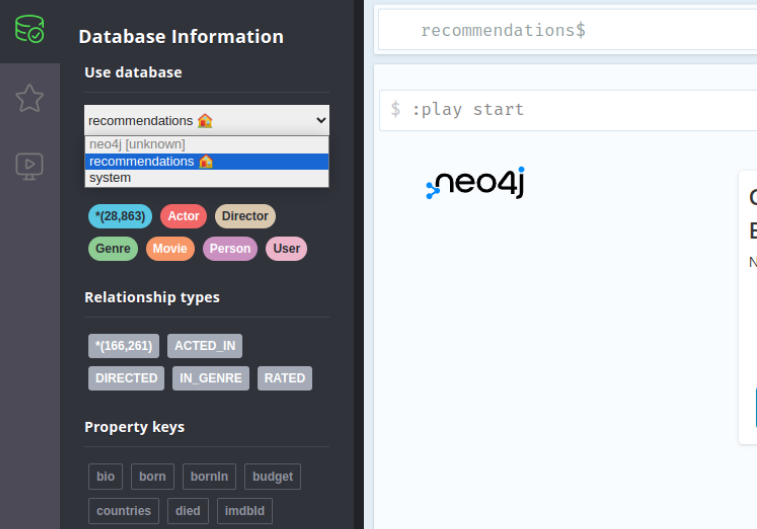

**Switch to `recommendations` database**

In [44]:
NEO4J_URL = "neo4j://localhost:7687"
NEO4J_USERNAME = "neo4j"
NEO4J_PASSWORD = "fireinthehole"
NEO4J_DATABASE = 'recommendations'

graph = Neo4jGraph(url=NEO4J_URL, username=NEO4J_USERNAME, password=NEO4J_PASSWORD, database=NEO4J_DATABASE)

In [45]:
graph.query("""
LOAD CSV WITH HEADERS FROM 'file:///' + $movie_directory    // Load CSV data from a file specified by $movie_directory
AS row                                                      // Each row in the CSV will be represented as 'row'
            
MERGE (m:Movie {id:row.movieId})                            // Merge a Movie node with the id from the row
SET m.released = date(row.released),                        // Set the 'released' property of the Movie node to the date from the row
    m.title = row.title,                                    // Set the 'title' property of the Movie node to the title from the row
    m.tagline = row.tagline,                                // Set the 'tagline' property of the Movie node to the tagline from the row
    m.imdbRating = toFloat(row.imdbRating)                  // Convert the 'imdbRating' from string to float and set it as the property
            
FOREACH (director in split(row.director, '|') |             // For each director in the list of directors from the row (split by '|') 
    MERGE (p:Person {name:trim(director)})                  // Merge a Person node with the director's name from the row, trimming any extra spaces
    MERGE (p)-[:DIRECTED]->(m))                             // Create a DIRECTED relationship from the director to the Movie
            
FOREACH (actor in split(row.actors, '|') |                  // For each actor in the list of actors from the row (split by '|') 
    MERGE (p:Person {name:trim(actor)})                     // Merge a Person node with the actor's name from the row, trimming any extra spaces
    MERGE (p)-[:ACTED_IN]->(m))                             // Create an ACTED_IN relationship from the actor to the Movie
            
FOREACH (genre in split(row.genres, '|') |                  // For each genre in the list of genres from the row (split by '|')
    MERGE (g:Genre {name:trim(genre)})                      // Merge a Genre node with the genre's name from the row, trimming any extra spaces
    MERGE (m)-[:IN_GENRE]->(g))                             // Create an IN_GENRE relationship from the Movie to the Genre
            
MERGE (l:Location {name:trim(row.location)})
MERGE (m)-[:WAS_TAKEN_IN]->(l)

MERGE (s:SimilarMovie {name:trim(row.similar_movie)})
MERGE (m)-[:IS_SIMILAR_TO]->(s)                                            
""",
params={"movie_directory": "movies_small.csv"})            # Pass the parameter 'movie_directory' which contains the path to the CSV file

[]

In [46]:
graph.refresh_schema()
print(graph.schema)

Node properties:
Movie {url: STRING, runtime: INTEGER, revenue: INTEGER, imdbRating: FLOAT, released: STRING, countries: LIST, languages: LIST, plot: STRING, imdbVotes: INTEGER, imdbId: STRING, year: INTEGER, poster: STRING, movieId: STRING, tmdbId: STRING, title: STRING, budget: INTEGER, id: STRING, tagline: STRING}
Genre {name: STRING}
User {userId: STRING, name: STRING}
Actor {url: STRING, died: DATE, born: DATE, imdbId: STRING, name: STRING, tmdbId: STRING, bornIn: STRING, bio: STRING, poster: STRING}
Director {url: STRING, bornIn: STRING, born: DATE, died: DATE, tmdbId: STRING, imdbId: STRING, name: STRING, poster: STRING, bio: STRING}
Person {url: STRING, bornIn: STRING, bio: STRING, died: DATE, born: DATE, imdbId: STRING, name: STRING, poster: STRING, tmdbId: STRING}
Location {name: STRING}
SimilarMovie {name: STRING}
Relationship properties:
RATED {rating: FLOAT, timestamp: INTEGER}
ACTED_IN {role: STRING}
DIRECTED {role: STRING}
The relationships:
(:Movie)-[:IN_GENRE]->(:Genre

New Update from Langchain (09/05/24): an enhanced schema parameter representation that samples the database values and return them to the LLM to be able to generate more accurate Cypher statements

https://python.langchain.com/v0.1/docs/integrations/graphs/neo4j_cypher/#enhanced-schema-information

In [47]:
graph = Neo4jGraph(url=NEO4J_URL, username=NEO4J_USERNAME, password=NEO4J_PASSWORD, database=NEO4J_DATABASE, enhanced_schema=True, sanitize=True)

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The procedure has a deprecated field. ('config' used by 'apoc.meta.graphSample' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: "CALL apoc.meta.graphSample() YIELD nodes, relationships RETURN nodes, [rel in relationships | {name:apoc.any.property(rel, 'type'), count: apoc.any.property(rel, 'count')}] AS relationships"


In [48]:
graph.refresh_schema()
print(graph.schema)

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The procedure has a deprecated field. ('config' used by 'apoc.meta.graphSample' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: "CALL apoc.meta.graphSample() YIELD nodes, relationships RETURN nodes, [rel in relationships | {name:apoc.any.property(rel, 'type'), count: apoc.any.property(rel, 'count')}] AS relationships"


Node properties:
- **Movie**
  - `url`: STRING Example: "https://themoviedb.org/movie/862"
  - `runtime`: INTEGER Min: 2, Max: 910
  - `revenue`: INTEGER Min: 1, Max: 2787965087
  - `budget`: INTEGER Min: 1, Max: 380000000
  - `imdbRating`: FLOAT Min: 1.6, Max: 9.6
  - `released`: STRING Example: "1995-11-22"
  - `countries`: LIST Min Size: 1, Max Size: 16
  - `languages`: LIST Min Size: 1, Max Size: 19
  - `plot`: STRING Example: "A cowboy doll is profoundly threatened and jealous"
  - `imdbVotes`: INTEGER Min: 13, Max: 1626900
  - `imdbId`: STRING Example: "0114709"
  - `year`: INTEGER Min: 1902, Max: 2016
  - `poster`: STRING Example: "https://image.tmdb.org/t/p/w440_and_h660_face/uXDf"
  - `movieId`: STRING Example: "1"
  - `tmdbId`: STRING Example: "862"
  - `title`: STRING Example: "Toy Story"
  - `id`: STRING Example: "1"
  - `tagline`: STRING Example: "The adventure takes off!"
- **Genre**
  - `name`: STRING Example: "Adventure"
- **User**
  - `userId`: STRING Example: "1"
  - 